In [54]:
#this file is supposed to ingest a gender-index-data-*.csv file and output, small CSVs for each plot maker to read.
import pandas
import math
import datetime
import os
import json
import pywikibot
from collections import defaultdict
import time

java_min_int = -2147483648
gender_ordered = [u'female', u'male', u'transgender female', u'intersex', u"fa'afafine", u'transgender male', u'female animal', u'male animal', u'woman', u'genderqueer', u'kathoey']

#Tranforming QIDs into English labels.
enwp = pywikibot.Site('en','wikipedia')
wikidata = enwp.data_repository()

retrieved = dict()

def english_label(qid):
    if type(qid) is float:
        if math.isnan(qid):
            return qid
    #first see if we've done it
    try:
        return retrieved[qid]
    except KeyError:
        try:
            page = pywikibot.ItemPage(wikidata, qid)
            data = page.get()
            lab = data['labels']['en']
            retrieved[qid] = lab
            return lab
        except:
            retrieved[qid] = qid
            return qid

def engify_labels(df):
    qids = [str(q) for q in df.columns]
    labels = [english_label(qid) for qid in qids]
    df.columns = labels
    return df

snap = 'snapshot_data/'
snapshot_dates = os.listdir(snap)
latest = os.path.join(snap,max(snapshot_dates))
csvs = filter(lambda x: x.endswith('.csv'), os.listdir(latest))
if not len(csvs) == 1:
    raise Exception
else:
    index_data_file = os.path.join(latest,csvs[0])
df = pandas.read_csv(index_data_file, na_values=[java_min_int])

def split_column(q_str):
    if type(q_str) is float:
        if numpy.isnan(q_str):
            return [q_str] #returning this way so we can gurantee that column contains list
    if type(q_str) is str:
        qs = q_str.split('|')
        return qs[:-1] #cos the format will always end with a |

for column in ['gender', 'ethnic_group', 'citizenship', 'place_of_birth', 'site_links']:
    column_plural = column+'s'
    df[column_plural] = df[column].apply(split_column)
    del df[column]
    


def make_reindex(snap_df):

    def int_dict_factory():
        return defaultdict(int)

    def nan_test(v):
        try:
            if math.isnan(v):
                return True
        except TypeError:
                return False
    #abstracted: we want year-gender, but also
    #gender-ethnicity -citizenship -place of birth, site-links

    params = list(df.columns)
    params.remove('qid')
    gender_param = {param:defaultdict(int_dict_factory) for param in params}

    for index, row in df.iterrows():
        row_data = {p : row[p] for p in params}
        for param in params:
            gender_dict = gender_param[param]
            vrs = row_data[param]
            genders = row_data['genders']
            if not nan_test(vrs):
                if not nan_test(genders):
                    for gender in genders:
                            if type(vrs) is list:
                                for var in vrs:
                                    gender_dict[gender][var] += 1
                            else: 
                                    gender_dict[gender][vrs] +=  1
                                    
    gender_dfs = {param: pandas.DataFrame.from_dict(gender_param[param], orient='columns') for param in params}
    return gender_dfs

reindexed_dfs = make_reindex(df)

for param, gender_df in reindexed_dfs.iteritems():
    engify_labels(gender_df)
    property_index_dir = latest + '/property_indexes'
    if not os.path.exists(property_index_dir):
        os.makedirs(property_index_dir)
    filename = '%s/%s-index.csv' % (property_index_dir, param)
    filepoint = open(filename, 'w')
    filepoint.write(gender_df.to_csv())
    filepoint.close()

In [61]:
plt = gender_dfs['dob'].ix[1800:].plot(kind='area',stacked=True, figsize=(24,8))
plt.set_title('''Wikidata Biography Gender Quantities by Year
    1800 onwards''', size=24)
plt.set_xlabel('Year', size=18)
plt.set_ylabel('Biographies', size=18)
plt.set_xlim((1800,2014))
plt.legend(title='Gender', loc=2)

NameError: name 'gender_dfs' is not defined

In [117]:
nonmale_early = gender_indexes[earliest_date]['dod'].copy(deep=True)
nonmale_late = gender_indexes[latest_date]['dod'].copy(deep=True)

del nonmale_early['nan']
nonmale_early['nonmale'] = nonmale_early.sum(axis=1) - nonmale_early['male']
nonmale_early['nm_per'] = (nonmale_early['nonmale'] ) / (nonmale_early['nonmale'] + nonmale_early['male'])

del nonmale_late['nan']
nonmale_late['nonmale'] = nonmale_late.sum(axis=1) - nonmale_late['male']
nonmale_late['nm_per'] = (nonmale_late['nonmale'] ) / (nonmale_late['nonmale'] + nonmale_late['male'])

(-1000, 2014)

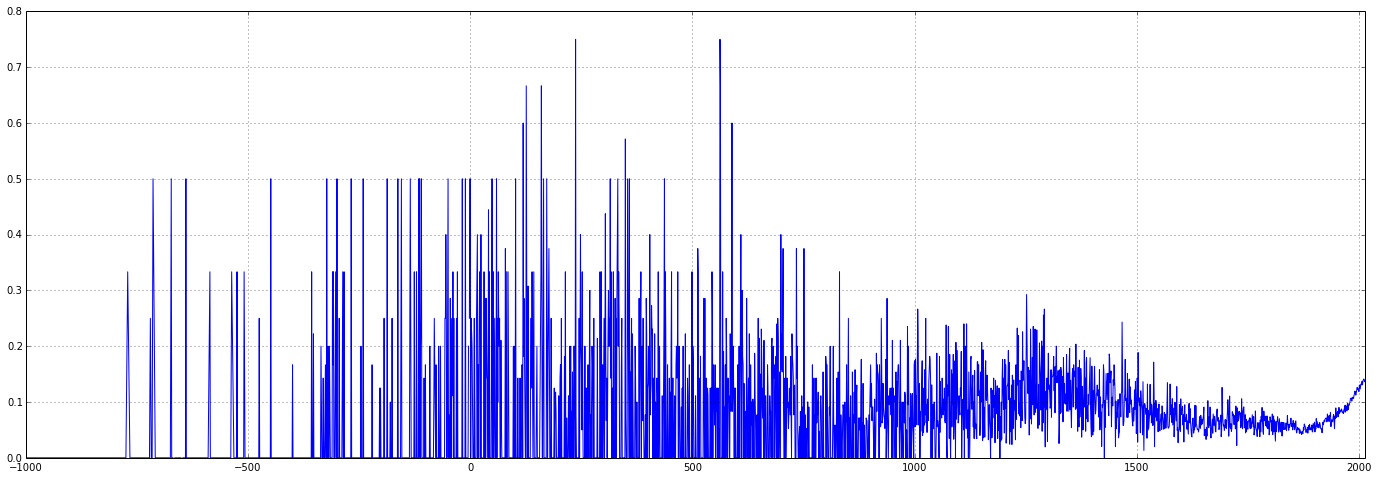

In [128]:
plt = nonmale_early['nm_per'].plot(figsize(24,8), kind='line')
plt.set_xlim((-1000,2014))

In [133]:
ma = pandas.rolling_mean(nonmale_early['nm_per'], 10)

(-1000, 2014)

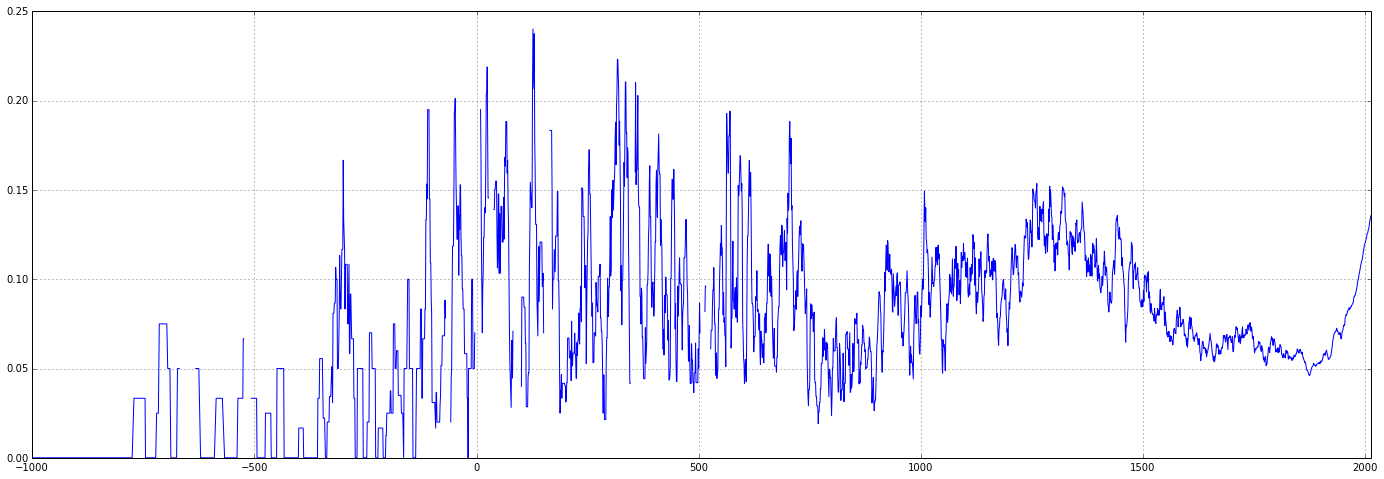

In [134]:
plt = ma.plot()
plt.set_xlim((-1000,2014))

In [ ]:
nonmale_late['nm_per'].plot(figsize=(24,8))
plt.set_xlim((-1000,2014))

In [67]:
gender_ordered

[u'female',
 u'male',
 u'transgender female',
 u'intersex',
 u"fa'afafine",
 u'transgender male',
 u'female animal',
 u'male animal',
 u'woman',
 u'genderqueer',
 u'kathoey']

In [34]:
['Date of Birth']*2

['Date of Birth', 'Date of Birth']

In [114]:
plt.style

'/usr/local/lib/python2.7/dist-packages/matplotlib/style/__init__.pyc'

In [16]:
infogram = pandas.DataFrame.from_csv('snapshot_data/2014-10-13/property_indexes/dob-index.csv')
infogram.fillna(0, inplace=True)
del infogram['nan']
infogram['total'] = infogram.sum(axis=1)
infogram['nonbin'] = infogram['total'] - infogram['male'] - infogram['female']
infogram['fem_per'] = infogram['female']  / (infogram['total'])
infogram['nonbin_per'] = infogram['nonbin'] / infogram['total']
rm = pandas.rolling_mean(infogram[['fem_per','nonbin_per']], 10, min_periods=10)

In [19]:
partyears = range(1800,2000,int(200/6.0))
rm.ix[partyears][['nonbin_per','fem_per']].T.to_csv('Magnus Gender analysis/infogram_dob_rm.csv')
infogram.ix[partyears][['nonbin_per','fem_per','nonbin']].T.to_csv('Magnus Gender analysis/infogram_dob.csv')

In [28]:
rm.ix[1880:1910]['nonbin_per']

1880    0.000000
1881    0.000000
1882    0.000022
1883    0.000022
1884    0.000022
1885    0.000043
1886    0.000043
1887    0.000043
1888    0.000043
1889    0.000043
1890    0.000043
1891    0.000043
1892    0.000021
1893    0.000021
1894    0.000021
1895    0.000000
1896    0.000000
1897    0.000000
1898    0.000000
1899    0.000000
1900    0.000000
1901    0.000000
1902    0.000000
1903    0.000000
1904    0.000000
1905    0.000000
1906    0.000000
1907    0.000000
1908    0.000000
1909    0.000000
1910    0.000000
Name: nonbin_per, dtype: float64

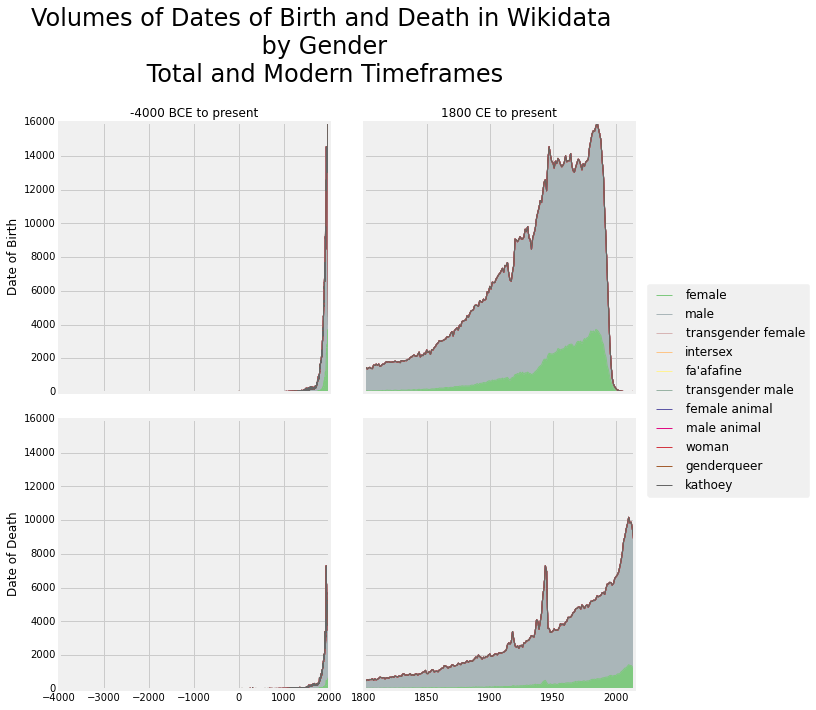

In [3]:
fig, axes = pylab.subplots(nrows=2, ncols=2, sharey=True)
for ax, beginning, l, (xtext, ytext) in zip(axes.ravel(), [-4000, 1800] * 2, ['b']*2+['d']*2, [('-4000 BCE to present','Date of Birth'),('1800 CE to present',''),('','Date of Death'),('','')]):
    acro = 'do'+l
    df = pandas.DataFrame.from_csv('snapshot_data/2014-10-13/property_indexes/%s-index.csv' % acro)
    del df['nan']
    df   = df.reindex_axis(gender_ordered,axis=1)
    p = df.plot(kind='area', figsize=(9,10), cmap='Accent', ax=ax, legend=False, linewidth=1)
    p.set_xlim((beginning,2014))
    #p.set_xlabel(xtext)
    p.set_ylabel(ytext)
    p.set_title(xtext, fontsize=12)

fig.legend = legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0)
fig.suptitle('Volumes of Dates of Birth and Death in Wikidata \n by Gender \n Total and Modern Timeframes', fontsize=24)
fig.tight_layout()
subplots_adjust(hspace=0.1, top=0.82)


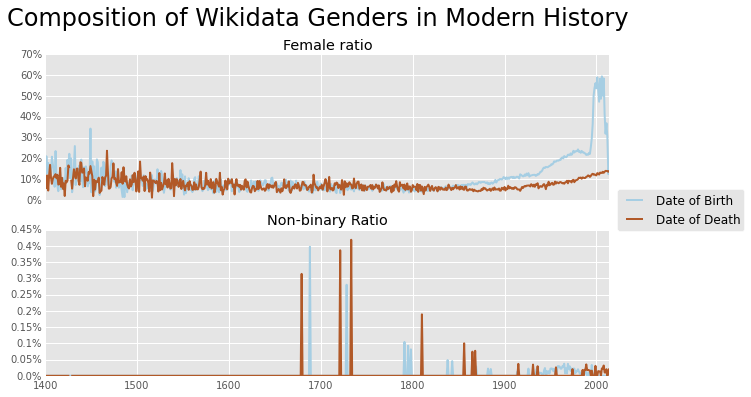

In [177]:
ra_len = 1

dox = pandas.DataFrame()
nonbindox = pandas.DataFrame()

for l in ['b','d']:
    acro = 'do'+l
    df = pandas.DataFrame.from_csv('snapshot_data/2014-10-13/property_indexes/%s-index.csv' % acro)
    del df['nan']
    df['total'] = df.sum(axis=1)
    df['nonbin'] = df['total'] - df['male'] - df['female']
    df['fem_per'] = df['female']  / (df['total'])
    df['nonbin_per'] = df['nonbin'] / df['total']
    
    ra = pandas.rolling_mean(df['fem_per'], ra_len)
    dox[acro] = ra
    
    nonbinra = pandas.rolling_mean(df['nonbin_per'], ra_len)
    nonbindox[acro] = nonbinra

fig, (pltf, pltb) =  pylab.subplots(nrows=2, ncols=1, sharex=True, figsize=(9,6))
dox.plot(kind='line',  cmap='Paired', linewidth=2, ax=pltf)
pltf.set_xlim((1400,2014))
pltf.set_ylim((0,0.7))
pltf.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, y: '{}%'.format(int(x*100) )))
pltf.set_title('Female ratio')
pltf.legend(('Date of Birth', 'Date of Death'),loc=4, bbox_to_anchor=(1.25,-0.25))

nonbindox.plot(kind='line',  cmap='Paired', linewidth=2, ax=pltb, legend=False)
pltb.set_xlim((1400,2014))
pltb.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, y: '{}%'.format(x*100)))
pltb.set_title('Non-binary Ratio')

fig.suptitle('Composition of Wikidata Genders in Modern History', fontsize=24)
fig.subplots_adjust(top=0.87)


#Place of Birth Ivestiagation

In [4]:
pob = gender_indexes[latest_date]['place_of_births'].copy(deep=True)

NameError: name 'gender_indexes' is not defined

In [70]:
len(pob)

72894

72,000 "places" how, many of these are countries. that is instance of "Q6256"

In [ ]:
%timeit -n 1 -r 1
def is_or_has_country(qid):
    countries = list() #we're going to return this
    page = pywikibot.ItemPage(wikidata, qid)
    data = page.get()
    claims = data['claims']
    for pid, claimlist in claims.iteritems():
        if pid == 'P17':
            for claim in claimlist:
                countries.append(claim.target.title()) #this is part of a country
        if pid == 'P31':
            for claim in claimlist:
                    if claim.target.title() == 'Q6256':
                        countries.append(qid) #this actually is a  country

    return countries 

place_country = dict()

count=0
for place in pob.index[1:]: #1 because the first index is nan
    place_country[place] = is_or_has_country(place)
    count += 1
    if count % 100 == 0:
        print count

In [97]:
pobs = [p for p in pob.index[1:]]
json.dump(pobs, open('pobs_list.json','w'))

__do some processing on wmflabs to save on bandwidth__

In [5]:
pobs_map = json.load(open('helpers/pobs_map.json','r'))

What percentage of pobs are of have a country? Which have more than one country?

In [9]:
have_country = [c[0] for c in pobs_map.values() if len(c) != 0]

In [10]:
len(list(set(have_country)))

235

In [14]:
len(have_country) / float(len(pobs_map.values()))

0.9363862099241353

In [15]:
have_no_country = [p for p, c in  pobs_map.iteritems() if len(c) == 0]

In [20]:
len(have_country)

68256

In [16]:
len(have_no_country)

4637

In [19]:
for place in have_no_country[10:20]:
    print 'http://wikidata.org/wiki/'+place

http://wikidata.org/wiki/Q361099
http://wikidata.org/wiki/Q4180803
http://wikidata.org/wiki/Q579468
http://wikidata.org/wiki/Q504912
http://wikidata.org/wiki/Q1013242
http://wikidata.org/wiki/Q1958565
http://wikidata.org/wiki/Q15763
http://wikidata.org/wiki/Q1091714
http://wikidata.org/wiki/Q448469
http://wikidata.org/wiki/Q7285906


  there's not an obvious easy way to programmatically determine these, would probably have to go over them by hand
  
  the sad part is that they probaby represent minority locations (and thus pepople)

In [23]:
country_lengths = sum([len(c) for c in have_country])

In [24]:
country_lengths / float(len(have_country))

1.0032524613220817

Ok, which have more than one country.

In [33]:
for place, country_list in pobs_map.iteritems():
    if len(country_list) > 1:
        if reduce(lambda a, b: a != b, country_list ):#all elements are the not  same
            pass#print ['http://wikidata.org/wiki/'+place for place in country_list]

In [34]:
import IPython.display

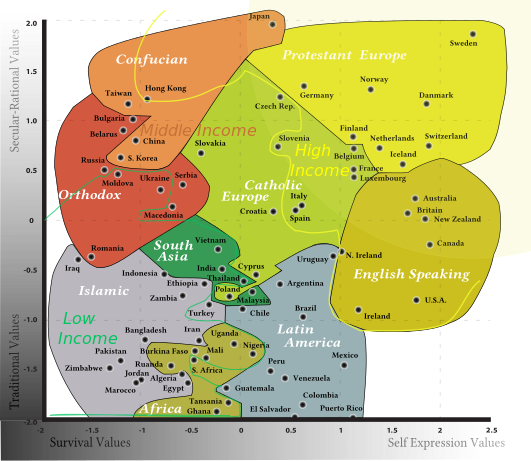

In [40]:
IPython.display.Image('helpers/Inglehart_Values_Map2.svg.png')

1. confcian
1. orthodox
1. isalmic
1. south asia
1. africa
1. catholic europea
1. protestant europe
1. english speaking

In [3]:
coun = [c for c in pobs_map.itervalues() if c]

NameError: name 'pobs_map' is not defined

In [ ]:
country_culture = dict()
for place, country_list in pobs_map.iteritems():
    if country_list:
        qid =  country_list[0]
        if qid in country_culture.keys():
            continue
        else:
            link = 'http://wikidata.org/wiki/%s' % qid
            print english_label(qid)
            print link
            culture_num = input('enter culture num')
            country_culture[qid] = culture_num
        

In [39]:
fp = open('helpers/pob_agg.txt','w')
seen = list()
for place, country_list in pobs_map.iteritems():
    if country_list:
        qid =  country_list[0]
        if qid in seen:
            continue
        else:
            enlab = english_label(qid)
            writestr = u'%s\t%s\t\n' % (qid, enlab)
            fp.write(writestr.encode('utf-8'))
            seen.append(qid)
fp.close()


In [6]:
culture_map ={1:'confucian',
                        2:'orthodox',
                        3:'islamic',
                        4:'south asia',
                        5:'africa',
                        6: 'catholic europe',
                        7: 'protestant europe',
                        8: 'english speaking',
                        9: 'latin america'}

In [53]:
cultures_df.to_csv('helpers/culture_names.csv')

In [7]:
cultures_df = pandas.DataFrame.from_csv('helpers/culture_names.csv')
cultures_df['qid'] = cultures_df.index
cultures_df['cutlure_name'] = cultures_df['culture_number'].apply(lambda x: culture_map[x])

In [8]:
pob = pandas.DataFrame.from_csv('snapshot_data/2014-10-13/property_indexes/place_of_births-index.csv')
pob['qid'] = pob.index
#pob = pob.ix[1:] #remove nan row

In [9]:
qid_countryqid = json.load(open('helpers/pobs_map.json','r'))

def qid_to_country(qid):
    if type(qid) is float:
        if math.isnan(qid):
            return 'no_data'
    else:
        return qid_countryqid[qid]
    
pob['country_qid'] = pob['qid'].apply(lambda qid: qid_to_country(qid))

In [10]:
country_culture = dict(zip(cultures_df['qid'], cultures_df['culture_name']))

In [11]:
def aggregate_culture(qid_list):
    if not type(qid_list) is list and qid_list == 'no_data':
                return 'no_data'
    if len(qid_list) > 0:
        culture_name = country_culture[qid_list[0]]
        return culture_name
    else:
        return 'not_easily_aggregatable'

In [12]:
pob['culture_name'] = pob['country_qid'].apply(lambda qid_list: aggregate_culture(qid_list))

In [13]:
culture_groups = pob.groupby(by=['culture_name'])[u'transgender female', u'intersex', u"fa'afafine", u'transgender male', u'female animal', u'male animal', u'woman', u'genderqueer', u'female', u'male', u'kathoey'].sum().copy(deep=True)


In [35]:
culture_groups.to_csv('helpers/pob_plot_data_oct.csv')

In [15]:
culture_groups['total'] = culture_groups.sum(axis=1)

In [16]:
normed_pobs_agg = culture_groups.apply(lambda x: x/ float(x['total']), axis=1)

In [17]:
pobs_plot = normed_pobs_agg.sort('female')[normed_pobs_agg.columns[:-1]]
pobs_plot_mf = normed_pobs_agg.sort('female')[['male','female']]
pobs_plot_nmf = normed_pobs_agg[[u'transgender female', u'intersex', u"fa'afafine", u'transgender male', u'female animal', u'male animal', u'woman', u'genderqueer', u'kathoey']]


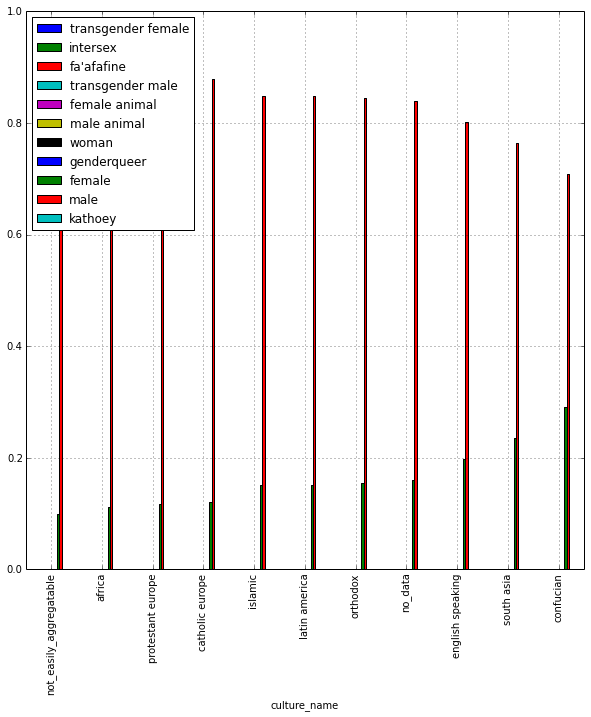

In [18]:
pobs_plot.plot(kind='bar', figsize=(10,10))

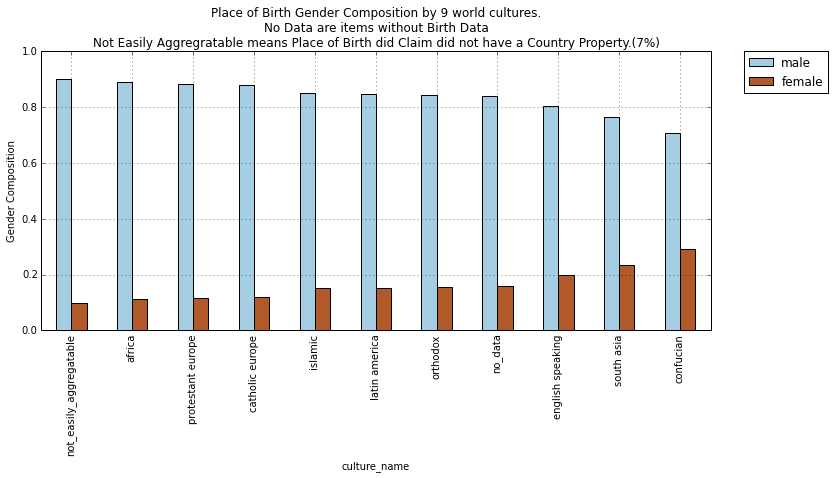

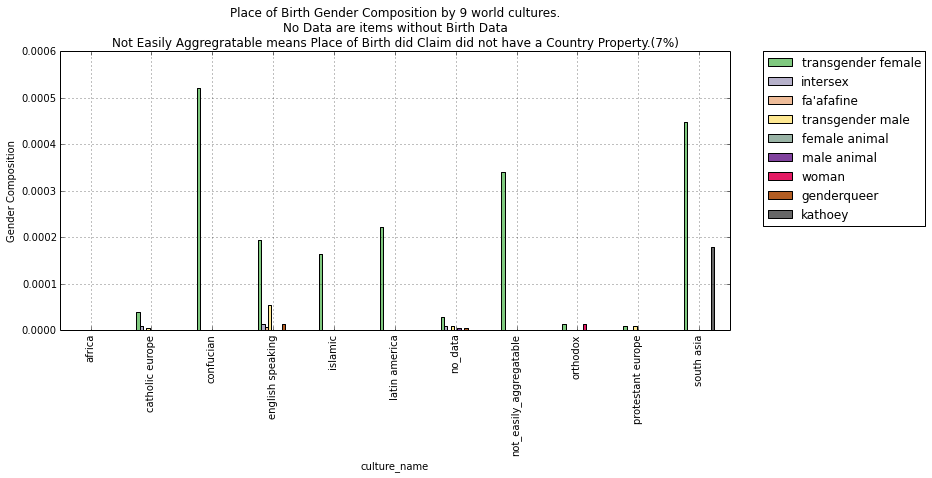

In [91]:
plt = pobs_plot_mf.plot(kind='bar', figsize=(12,5), cmap='Paired')
plt.set_title('Place of Birth Gender Composition by 9 world cultures.\nNo Data are items without Birth Data\nNot Easily Aggregratable means Place of Birth did Claim did not have a Country Property.(7%)')
plt.set_ylabel('Gender Composition')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


plt = pobs_plot_nmf.plot(kind='bar', figsize=(12,5), cmap='Accent')
plt.set_title('Place of Birth Gender Composition by 9 world cultures.\nNo Data are items without Birth Data\nNot Easily Aggregratable means Place of Birth did Claim did not have a Country Property.(7%)')
plt.set_ylabel('Gender Composition')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


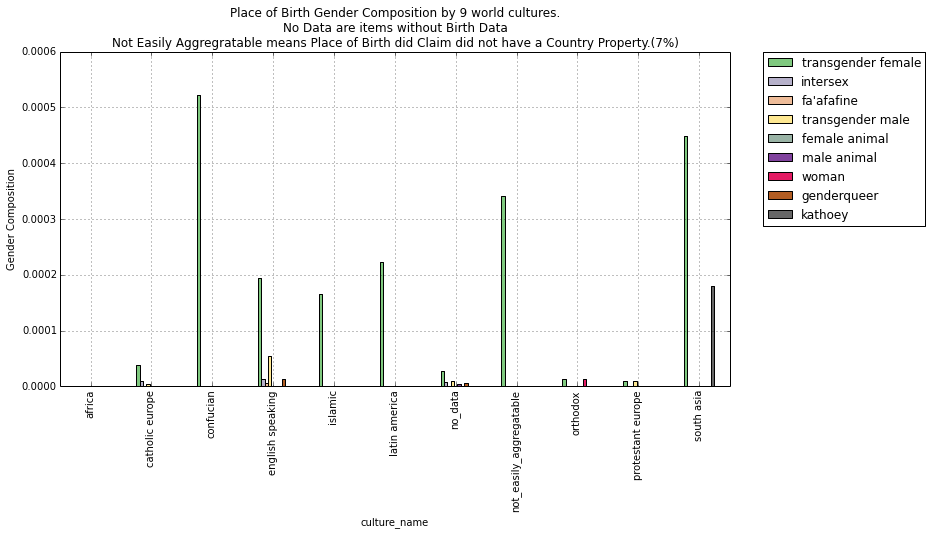

In [ ]:
pob = gender_indexes[latest_date]['place_of_births'].copy(deep=True)

#Ethnic Groups

In [142]:
eg = gender_indexes[latest_date]['ethnic_groups'].copy(deep=True)

In [154]:
eg = pandas.DataFrame.from_csv('snapshot_data/2014-10-13/property_indexes/ethnic_groups-index.csv')

In [155]:
len(eg)

683

In [160]:
eg=eg.ix[1:].fillna(value=0)
eg['total'] = eg.sum(axis=1)
engify_labels(eg,index=True)

In [162]:
eg['qid'] = eg.index

In [218]:
eg['ethnic_name'] = eg['qid'].apply(lambda x: english_label(x))

In [219]:
eg.sort('total', ascending=False).head(50)

,nan,transgender female,intersex,fa'afafine,transgender male,female animal,male animal,woman,genderqueer,female,male,kathoey,total,qid,ethinic_name,ethnic_name
Q539051,116,0,0,0,0,0,0,0,0,190,2395,0,8103,Q539051,Greeks,Greeks
Q127885,0,1,0,0,0,0,0,0,0,123,1135,0,3777,Q127885,Serbs,Serbs
Q7325,1,0,0,0,0,0,0,0,0,30,157,0,564,Q7325,Jewish people,Jewish people
Q7129609,2,0,0,0,0,0,0,0,0,115,57,0,522,Q7129609,Caucasian race,Caucasian race
Q161652,0,1,0,0,0,0,0,0,0,150,20,0,513,Q161652,Japanese people,Japanese people
Q49085,0,0,0,0,0,0,0,0,0,72,69,0,423,Q49085,African American,African American
Q235155,0,1,0,0,0,0,0,0,0,81,35,0,351,Q235155,white people,white people
Q402913,0,0,0,0,0,0,0,0,0,28,74,0,306,Q402913,Bengali people,Bengali people
Q187985,0,0,0,0,0,0,0,0,0,9,88,0,291,Q187985,Tibetan people,Tibetan people
Q485150,1,0,0,0,0,0,0,0,0,21,71,0,279,Q485150,Romanians,Romanians


In [221]:
eg_normed = eg[[u'transgender female', u'intersex', u"fa'afafine", u'transgender male', u'female animal', u'male animal', u'woman', u'genderqueer', u'female', u'male', u'kathoey', 'total']].apply(lambda x: x/x['total'], axis=1)


In [228]:
eg_cut = eg[eg['total']>1]
eg_cut_normed = eg_cut[[u'transgender female', u'intersex', u"fa'afafine", u'transgender male', u'female animal', u'male animal', u'woman', u'genderqueer', u'female', u'male', u'kathoey', 'total']].apply(lambda x: x/x['total'], axis=1)


In [ ]:
eg_

In [177]:
engify_labels(eg_normed, index=True)

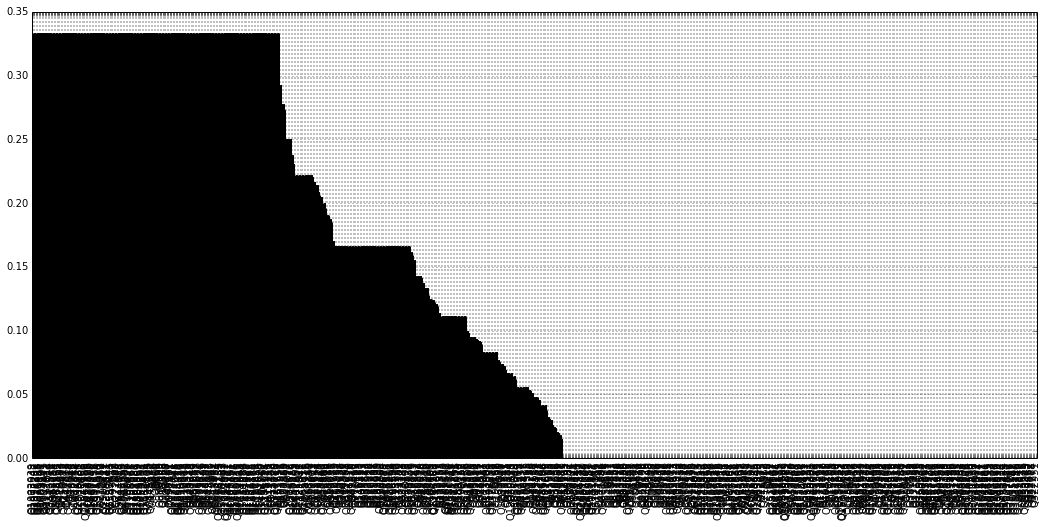

In [226]:
eg_normed.sort(columns=['female'], ascending=False)['female'].plot(kind='bar', figsize=(18,8))

In [241]:
def export_for_crowd_aggregate(df, savename):
    crowd_source_export  = pandas.DataFrame()
    crowd_source_export['qid'] = df.index
    crowd_source_export['en_label'] = crowd_source_export['qid'].apply(lambda x: english_label(x).encode('utf-8'))
    crowd_source_export['aggregate_group'] = ''
    crowd_source_export.to_csv('helpers/%s_map.csv' % savename)

In [ ]:
export_for_crowd_aggregate(eg, 'ethnic_groups')

#Citizenships

In [99]:
cz = gender_indexes[latest_date]['citizenships'].copy(deep=True)

In [180]:
cz = pandas.DataFrame.from_csv('snapshot_data/2014-10-13/property_indexes/citizenships-index.csv')

In [249]:
cz = cz.ix[1:] #remove the inintial nan ,which are items that had no citienzship

In [250]:
len(cz)

732

In [ ]:
export_for_crowd_aggregate(cz, 'citizenships')

#SiteLinkss!

In [183]:
sl = pandas.DataFrame.from_csv('snapshot_data/2014-10-13/property_indexes/site_linkss-index.csv')

In [184]:
len(sl)

428

#Regressions Maybe

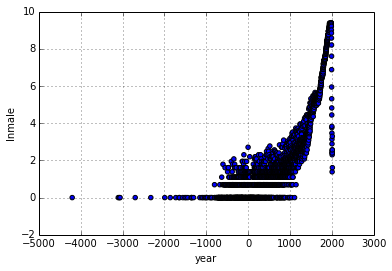

In [57]:
yg.plot(kind='scatter', x='year', y='lnmale')
plt.draw()

In [108]:
yg_reg = yg
yg_reg['year'] = yg_reg.index

In [109]:
yg_reg['lnmale'] = numpy.log(yg_reg['male'])

In [123]:
import statsmodels.api as sm

nonnan = yg_reg.ix[start_year:1986].fillna(value=0)
model = sm.OLS(nonnan['male'],nonnan['year'])
results = model.fit()
print(results.summary())
    print(start_year, results.rsquared)

(None, 0.20534979805159537)
(-500, 0.21745102948866801)
(0, 0.21941326163168851)
(500, 0.22247317415119383)
(1000, 0.24992223055451823)
(1500, 0.37760491504948823)
(1800, 0.72773643874338734)
(1900, 0.95518546745325672)


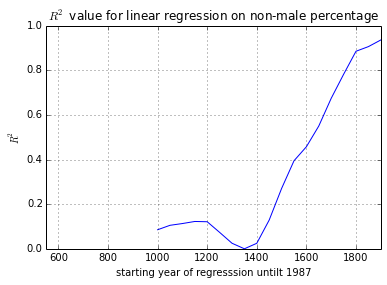

In [144]:
rsquared_results = pandas.DataFrame(columns=['start_year','rsquared'])
for start_year in numpy.arange(-4000,1950,50):
    nm_model = sm.OLS(yg_reg.ix[start_year:1986]['nm_per'], sm.add_constant(yg_reg.ix[start_year:1986]['year']) )
    nm_results = nm_model.fit()
    rsquared_results = rsquared_results.append({'start_year':start_year, 'rsquared':nm_results.rsquared}, ignore_index=True)
    
ax = rsquared_results[rsquared_results['start_year']>500].plot(kind='line',x='start_year',y='rsquared', 
                                                                title=r'$R^2$ value for linear regression on non-male percentage')

ax.set_xlabel('starting year of regresssion untilt 1987')
ax.set_ylabel(r'$R^2$')

This implies $y = -1.7495 + 0.001x$  with $R^2 = 0.885$

setting $y=0.5$
$\implies$
$x=2249.5$ or in the year 2250
